In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import os
import cv2 as cv
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn import model_selection, metrics

In [3]:
import utils
path = 'Data/animals'
categories, img_size, norm = utils.init_data(path)

data = []
target = []

labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))

print(label_dict)

{'Cat': 0, 'Dog': 1, 'Panda': 2}


In [4]:
for category in categories:
    category_path = os.path.join(path, category)
    images = os.listdir(category_path)

    for image in images:
        img_path = os.path.join(category_path, image)
        img = cv.imread(img_path)

        try:
            resized = cv.resize(img, (img_size, img_size))
            resized = resized.astype('float')
            data.append(resized)
            target.append(label_dict[category])

        except Exception as e:
            print('Exception:', e)

In [5]:
data = np.array(data)
data = np.reshape(data, (data.shape[0], img_size, img_size, 3))
target = np.array(target)

In [6]:
random_state = 42
test_size = 0.24
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    data, target, test_size = test_size, random_state = random_state)

In [7]:
X_train /= norm
X_test /= norm
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

print('Number of images: {}. \nWhere Training set contains {} & Testing set includes {}'.format(
    (len(X_train)+len(X_test)), len(X_train), len(X_test)))

Number of images: 3060. 
Where Training set contains 2325 & Testing set includes 735


In [8]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=img_size, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, 3), name='Conv2D'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(filters=img_size * 2, kernel_size=(3, 3), activation='relu', name='Conv2D_2'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(img_size * 2, activation='relu', name='Hidden'),
        tf.keras.layers.Dense(3, activation='softmax', name='Output')
    ])
    
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return model;

In [9]:
seq_model = build_model()
seq_model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2304)              0         
____

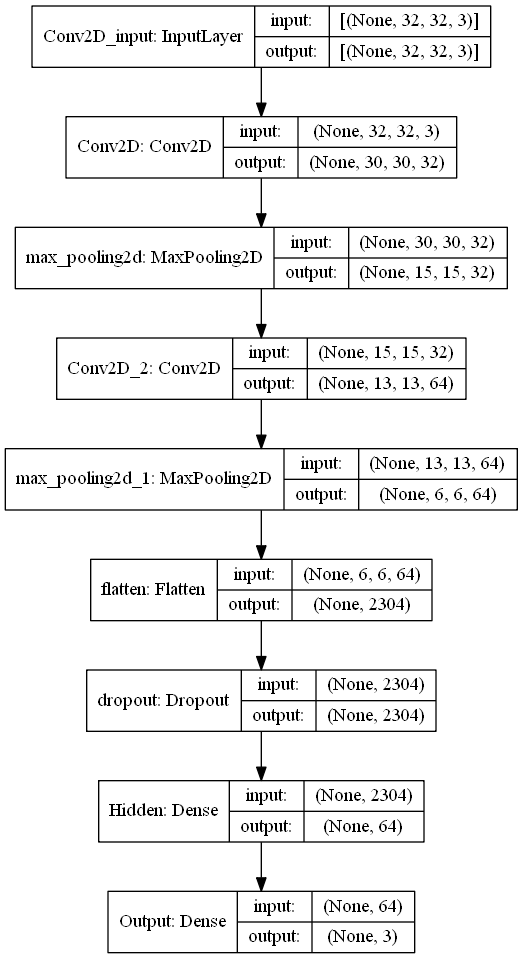

In [10]:
tf.keras.utils.plot_model(seq_model, to_file='Data/models/cnn.png', show_shapes=True)

In [11]:
batch_size = 32
epochs = 30
checkpoint = tf.keras.callbacks.ModelCheckpoint('Data/models/model-{epoch:02d}.model', monitor='val_loss',verbose=0, save_best_only=False,  mode='auto')

history = seq_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[checkpoint])
# In order to show the info, set verbose=1 or 2

Train on 2325 samples, validate on 735 samples
Epoch 1/30
2325/2325 [==============================] - 41s 18ms/sample - loss: 1.0086 - acc: 0.5080 - val_loss: 0.9707 - val_acc: 0.5224
Epoch 2/30
2325/2325 [==============================] - 41s 18ms/sample - loss: 0.9442 - acc: 0.5527 - val_loss: 0.9239 - val_acc: 0.5701
Epoch 3/30
2325/2325 [==============================] - 38s 16ms/sample - loss: 0.9211 - acc: 0.5785 - val_loss: 0.9133 - val_acc: 0.5810
Epoch 4/30
2325/2325 [==============================] - 37s 16ms/sample - loss: 0.9075 - acc: 0.6000 - val_loss: 0.9117 - val_acc: 0.5714
Epoch 5/30
2325/2325 [==============================] - 36s 16ms/sample - loss: 0.8986 - acc: 0.5983 - val_loss: 0.9079 - val_acc: 0.5619
Epoch 6/30
2325/2325 [==============================] - 37s 16ms/sample - loss: 0.9024 - acc: 0.5927 - val_loss: 0.9103 - val_acc: 0.5102
Epoch 7/30
2325/2325 [==============================] - 37s 16ms/sample - loss: 0.8930 - acc: 0.6022 - val_loss: 0.9144 - val

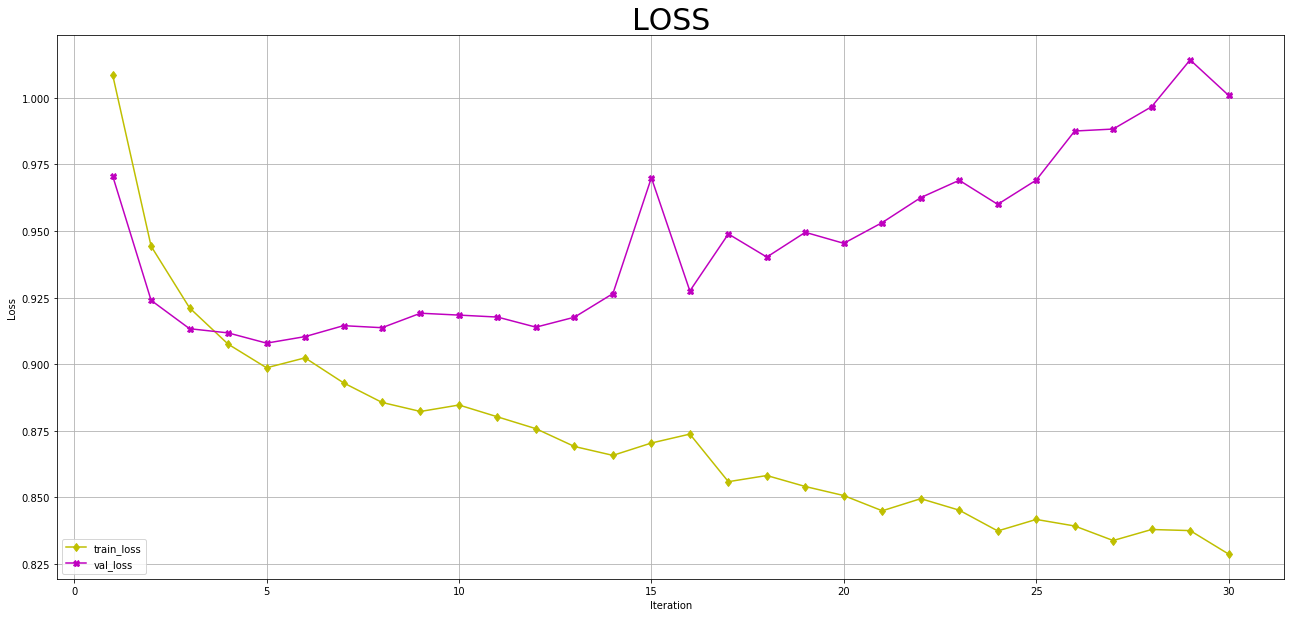

In [12]:
train_metrics = history.history['loss']
val_metrics = history.history['val_loss']
ep = range(1, len(train_metrics) + 1)

plt.figure(figsize=(22, 10))
plt.plot(ep, train_metrics, 'yd-')
plt.plot(ep, val_metrics, 'mX-')
plt.grid()
plt.title('LOSS', fontsize=30)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [13]:
evaluation = seq_model.evaluate(x=X_test, y=y_test, verbose=0)
print(' Loss:', evaluation[0], '\n', 'Accuracy:', evaluation[1])

 Loss: 1.0008090757188344 
 Accuracy: 0.4176871
